In [1]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Prepair Dataset

def Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE):
    # Ustvari izhodni direktorij, če še ne obstaja
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Pridobi vse .jpg slike
    image_paths = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR)
                   if f.lower().endswith(('.jpg', '.jpeg'))]

    print(f"Najdenih {len(image_paths)} slik za obdelavo...")

    for path in tqdm(image_paths, desc="Obdelujem slike"):
        # Preberi sliko
        img = cv2.imread(path)
        if img is None:
            print(f"❌ Napaka pri branju slike: {path}")
            continue

        # Pretvori v sivinsko
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Spremeni velikost (320x240)
        resized = cv2.resize(gray, TARGET_SIZE)

        # Ustvari enako ime datoteke v izhodni mapi
        filename = os.path.basename(path)
        output_path = os.path.join(OUTPUT_DIR, filename)

        # Shrani obdelano sliko
        cv2.imwrite(output_path, resized)

    print("✅ Vse slike so uspešno predobdelane in shranjene v:")
    print(f"   {OUTPUT_DIR}")

INPUT_DIR = "datasets/val2017"
OUTPUT_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
# Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE)


In [2]:
# ============================================================
# HELPER FUNKCIJE ZA GENERIRANJE PAROV
# ============================================================

def sample_window(img_shape, window_size=64, margin=16):
    h, w = img_shape[:2]
    x = random.randint(margin, w - margin - window_size)
    y = random.randint(margin, h - margin - window_size)
    return x, y


def get_corners(x, y, window_size=64):
    return np.array([
        [x, y],
        [x + window_size, y],
        [x + window_size, y + window_size],
        [x, y + window_size]
    ], dtype=np.float32)


def perturb_corners(corners, disp_range=(-16, 16)):
    min_disp, max_disp = disp_range
    disp = np.random.randint(min_disp, max_disp + 1, size=corners.shape).astype(np.float32)
    return corners + disp


def generate_pair(img, window_size=64, margin=16, max_disp=16):
    h, w = img.shape[:2]

    x, y = sample_window((h, w), window_size, margin)

    src_corners = get_corners(x, y, window_size)
    dst_corners = perturb_corners(src_corners, max_disp)

    # Homografija H (src -> dst) in njen inverz
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp celotne slike z H^-1
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Izreži patche
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Stack v 2 kanala in normaliziraj
    pair = np.stack([orig_patch, warped_patch], axis=-1).astype(np.float32) / 255.0

    # Ground truth: pomiki kotičkov
    offsets = (dst_corners - src_corners).astype(np.float32)

    return pair, offsets


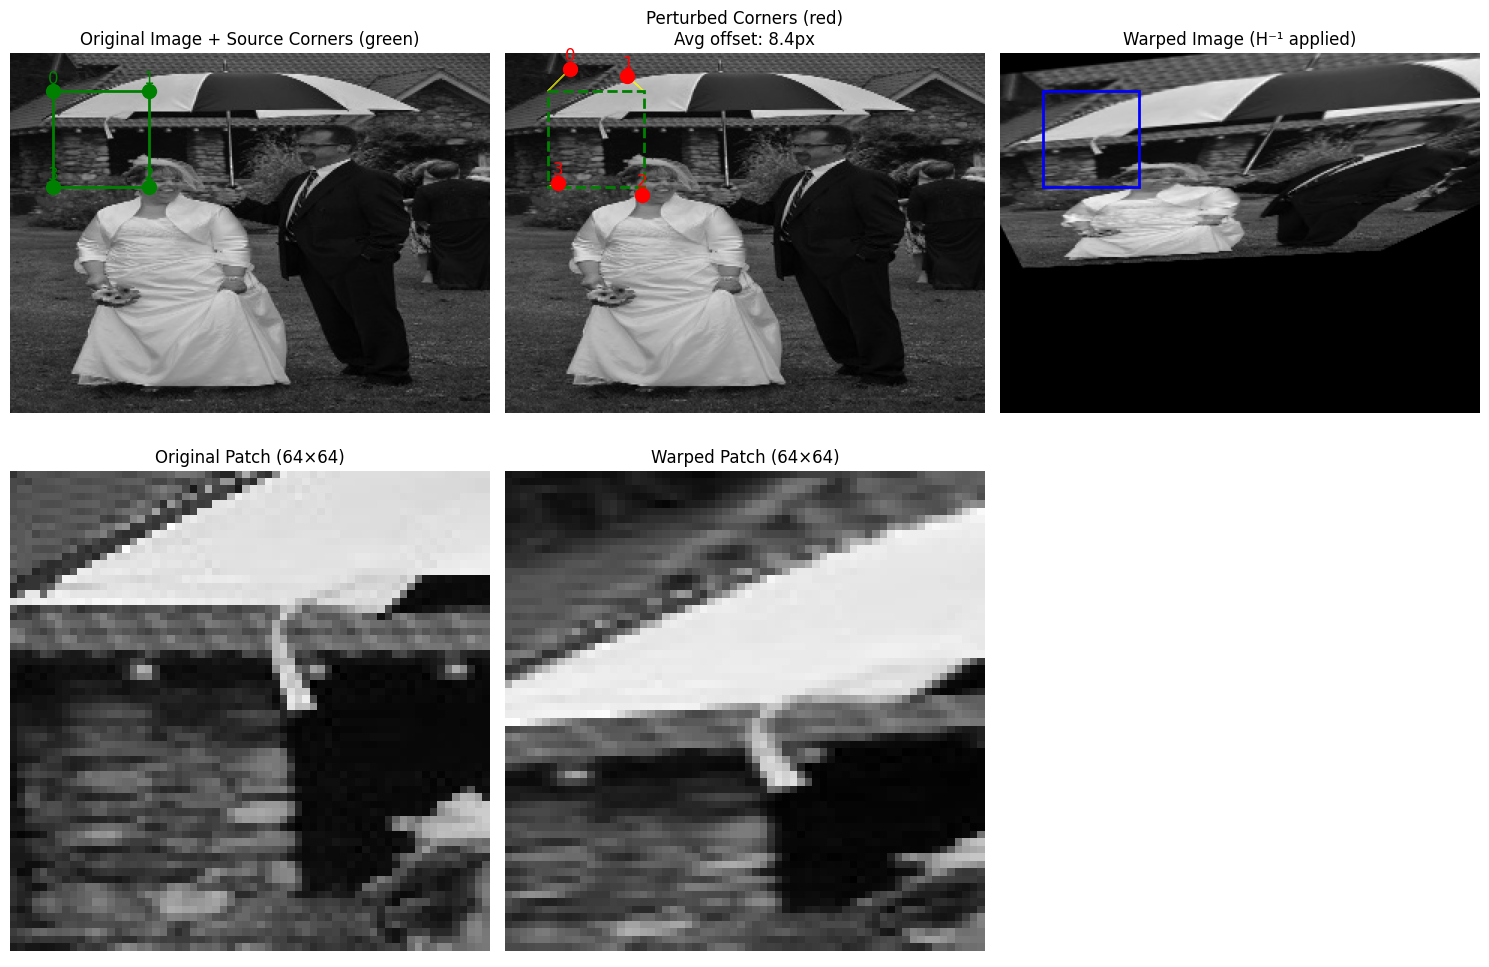


Corner offsets (Δx, Δy):
  Corner 0: (+15.0, -15.0) px
  Corner 1: (-11.0, -10.0) px
  Corner 2: (-1.0, +5.0) px
  Corner 3: (+7.0, -3.0) px


In [15]:
def visualize_generate_pair(image_dir):
    """
    Vizualiziraj celoten process generate_pair na naključni sliki.
    Prikaže:
    1. Originalno sliko z začetnimi kotički
    2. Premaknjene kotičke
    3. Transformirano sliko
    4. Original in warped patch
    """
    # Nalož naključno sliko
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    h, w = img.shape[:2]
    window_size = 64
    margin = 16
    disp_range = (-16, 16)

    # Sample window
    x, y = sample_window((h, w), window_size, margin)

    # Get corners
    src_corners = get_corners(x, y, window_size)
    dst_corners = perturb_corners(src_corners, disp_range)

    # Compute homography
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp image
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Extract patches
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Calculate offsets
    offsets = dst_corners - src_corners

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Original image with source corners
    ax = axes[0, 0]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(src_corners):
        ax.plot(cx, cy, 'go', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='green', fontsize=12, ha='center')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Original Image + Source Corners (green)')
    ax.axis('off')

    # 2. Original image with destination corners
    ax = axes[0, 1]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(dst_corners):
        ax.plot(cx, cy, 'ro', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='red', fontsize=12, ha='center')
    # Draw lines showing displacement
    for i in range(4):
        ax.arrow(src_corners[i, 0], src_corners[i, 1],
                 offsets[i, 0], offsets[i, 1],
                 head_width=3, head_length=3, fc='yellow', ec='yellow', alpha=0.7)
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2, linestyle='--')
    ax.add_patch(rect)
    ax.set_title(f'Perturbed Corners (red)\nAvg offset: {np.abs(offsets).mean():.1f}px')
    ax.axis('off')

    # 3. Warped image with H^-1
    ax = axes[0, 2]
    ax.imshow(warped, cmap='gray')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Warped Image (H⁻¹ applied)')
    ax.axis('off')

    # 4. Original patch
    ax = axes[1, 0]
    ax.imshow(orig_patch, cmap='gray')
    ax.set_title('Original Patch (64×64)')
    ax.axis('off')

    # 5. Warped patch
    ax = axes[1, 1]
    ax.imshow(warped_patch, cmap='gray')
    ax.set_title('Warped Patch (64×64)')
    ax.axis('off')

    # Hide the 6th subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print offsets
    print("\nCorner offsets (Δx, Δy):")
    for i, (dx, dy) in enumerate(offsets):
        print(f"  Corner {i}: ({dx:+.1f}, {dy:+.1f}) px")


# Run visualization
# if os.path.exists(OUTPUT_DIR):
#     visualize_generate_pair(OUTPUT_DIR)

In [3]:
# ============================================================
# PYTORCH DATASET
# ============================================================

class HomographyDataset(Dataset):
    def __init__(self, image_dir, num_samples=1000, window_size=64, margin=16, max_disp=(-16, 16)):
        """
        Args:
            image_dir: pot do direktorija s predobdelanimi slikami (grayscale, 320x240)
            num_samples: število parov na epoch
            window_size: velikost okna
            margin: margin od robov
            max_disp: maksimalni pomik kotičkov
        """
        self.image_dir = image_dir
        self.num_samples = num_samples
        self.window_size = window_size
        self.margin = margin
        self.max_disp = max_disp

        # Najdi vse slike
        self.image_paths = [
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        if len(self.image_paths) == 0:
            raise ValueError(f"Ni najdenih slik v {image_dir}")

        print(f"Dataset inicializiran: {len(self.image_paths)} slik, {num_samples} vzorcev/epoch")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Naključno izberi sliko
        img_path = random.choice(self.image_paths)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise RuntimeError(f"Napaka pri branju {img_path}")

        # Generiraj par
        pair, offsets = generate_pair(img, self.window_size, self.margin, self.max_disp)

        # Pretvori v PyTorch tensor (C, H, W) format
        pair_tensor = torch.from_numpy(pair).permute(2, 0, 1)  # (2, 64, 64)
        offsets_tensor = torch.from_numpy(offsets).flatten()  # (8,) - 4 točke x 2 koordinati

        return pair_tensor, offsets_tensor


In [5]:
# ============================================================
# TEST
# ============================================================

def test_homography_dataset(PREPROCESSED_DIR):
    if not os.path.exists(PREPROCESSED_DIR):
        ValueError(f"Direktorij {PREPROCESSED_DIR} ne obstaja!")

    dataset = HomographyDataset(
        image_dir=PREPROCESSED_DIR,
        num_samples=10,
        window_size=64,
        margin=16,
        max_disp=(-16, 16)
    )

    # Ustvari DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0
    )

    # Preberi en batch
    pairs, offsets = next(iter(dataloader))

    print(f"\n✅ Test batch:")
    print(f"   Pairs shape: {pairs.shape}")  # (32, 2, 64, 64)
    print(f"   Offsets shape: {offsets.shape}")  # (32, 8)
    print(f"   Pairs dtype: {pairs.dtype}")
    print(f"   Pairs min/max: {pairs.min():.3f} / {pairs.max():.3f}")
    print(f"   Povprečen pomik: {offsets.abs().mean():.2f} px")


PREPROCESSED_DIR = "datasets/val207_preprocessed"
# test_homography_dataset(PREPROCESSED_DIR)


Dataset inicializiran: 5000 slik, 10 vzorcev/epoch

✅ Test batch:
   Pairs shape: torch.Size([10, 2, 64, 64])
   Offsets shape: torch.Size([10, 8])
   Pairs dtype: torch.float32
   Pairs min/max: 0.000 / 1.000
   Povprečen pomik: 8.31 px


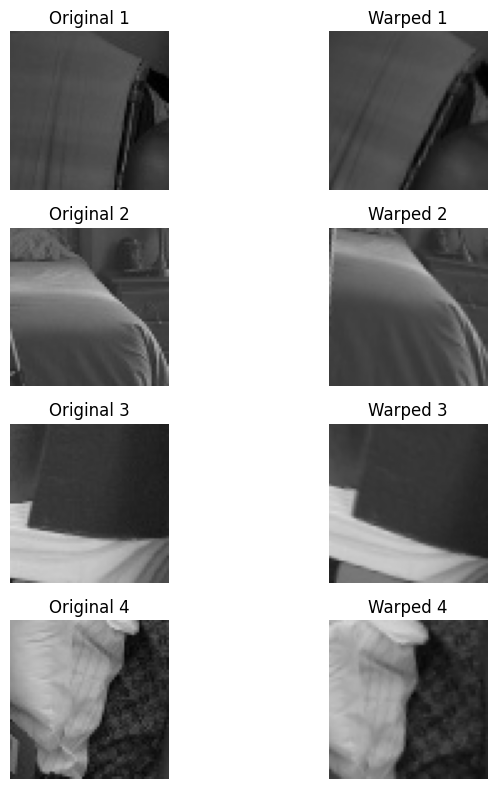

In [8]:
# ============================================================
# VIZUALIZACIJA
# ============================================================

def visualize_batch(pairs, offsets, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]

    for i in range(min(num_samples, pairs.shape[0])):
        pair = pairs[i].numpy()  # (2, H, W)

        # Original patch
        axes[i, 0].imshow(pair[0], cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Original {i + 1}')
        axes[i, 0].axis('off')

        # Warped patch
        axes[i, 1].imshow(pair[1], cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Warped {i + 1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Vizualiziraj nekaj vzorcev
# if os.path.exists(PREPROCESSED_DIR):
#     pairs, offsets = next(iter(dataloader))
#     visualize_batch(pairs, offsets, num_samples=4)


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, stride=1,
                 dropout_rate=0.1):
        super(ResNetBlock, self).__init__()
        out_channels = out_channels or in_channels  # če ni določeno, ohrani enako št. kanalov

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.dropout(out)
        out += residual

        out = self.relu(out)
        return out


In [ ]:
class ResNetBody(nn.Module):
    def __init__(self, in_channels=2, dropout_rate=0.1):
        super(ResNetBody, self).__init__()

        # ----- 1. stopnja -----
        self.layer1 = nn.Sequential(
            ResNetBlock(in_channels, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        # ----- 2. stopnja -----
        self.layer2 = nn.Sequential(
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )

        # ----- 3. stopnja -----
        self.layer3 = nn.Sequential(
            ResNetBlock(64, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 -> 8x8
        )

        # ----- 4. stopnja -----
        self.layer4 = nn.Sequential(
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            # zadnji max pool ni potreben, ohranimo 8x8
        )

        # ----- Polno povezan sloj -----
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, 512)

    def forward(self, x):  # Nx2x64x64
        x = self.layer1(x)  # Nx64x32x32
        x = self.layer2(x)  # Nx64x16x16
        x = self.layer3(x)  # Nx128x8x8
        x = self.layer4(x)  # Nx128x8x8
        x = self.flatten(x)  # Nx8192
        x = self.fc(x)  # Nx512
        return x


In [ ]:
class RegressionHead(nn.Module):
    def __init__(self, in_features=512, out_features=8):
        super(RegressionHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):  # Nx512
        return self.fc(x)  # Nx8

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, in_features=512, num_classes=21, class_dim=8):
        super(ClassificationHead, self).__init__()
        self.num_classes = num_classes
        self.class_dim = class_dim
        self.fc = nn.Linear(in_features, num_classes * class_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):  # Nx512
        x = self.fc(x)  # Nx168
        x = x.view(-1, self.num_classes, self.class_dim)  # Nx21x8
        x = self.softmax(x)  # Nx21x8
        return x

In [ ]:
class HomographyRegressor(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(HomographyRegressor, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = RegressionHead(in_features=512, out_features=8)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [ ]:
class HomographyClassifier(nn.Module):
    def __init__(self, num_classes=21, class_dim=8, dropout_rate=0.1):
        super(HomographyClassifier, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = ClassificationHead(in_features=512,
                                       num_classes=num_classes,
                                       class_dim=class_dim)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [ ]:
# GPU Memory Management Utilities

def check_gpu_memory():
    """Check current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(device) / 1e9
        reserved = torch.cuda.memory_reserved(device) / 1e9
        total = torch.cuda.get_device_properties(device).total_memory / 1e9
        print(f"GPU Memory Status:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved:  {reserved:.2f} GB")
        print(f"  Total:     {total:.2f} GB")
        print(f"  Free:      {total - reserved:.2f} GB")
    else:
        print("CUDA not available")


def clear_gpu_memory():
    """Force clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print("✅ GPU cache cleared")
        check_gpu_memory()
    else:
        print("CUDA not available")


# Check GPU memory
check_gpu_memory()


In [ ]:
import re


def extract_epoch(filename):
    match = re.search(r"epoch_(\d+)", filename)
    return int(match.group(1)) if match else -1


def train_homography_regressor(model, num_epochs, model_file_name, train_loader,
                               optimizer, criterion, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0
    loss_history = []

    # 🔄 Resume if checkpoint exists
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
    checkpoints = sorted(checkpoints, key=extract_epoch)
    if checkpoints:
        latest_ckpt = os.path.join(checkpoint_dir, checkpoints[-1])
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"]
        loss_history = checkpoint.get("loss_history", [])
        print(f"✅ Resuming from checkpoint: {latest_ckpt} (epoch {start_epoch})")
    else:
        print("🚀 Starting training from scratch.")

    # 🔁 Training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0

        for pairs, offsets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            pairs = pairs.to(device, dtype=torch.float)
            offsets = offsets.to(device, dtype=torch.float)

            optimizer.zero_grad()
            preds = model(pairs)  # Nx8
            loss = criterion(preds, offsets)  # MSE (L2) loss
            loss.backward()
            optimizer.step()

            batch_size = pairs.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

        epoch_mse = running_loss / max(1, total_samples)  # average MSE per sample
        epoch_rmse = np.sqrt(epoch_mse)
        loss_history.append({"epoch": epoch + 1, "mse": epoch_mse, "rmse": epoch_rmse})

        print(f"Epoch {epoch + 1}/{num_epochs} - MSE: {epoch_mse:.6f} - RMSE: {epoch_rmse:.6f}")

        # 💾 Save checkpoint every 500 epochs or at the end
        if (epoch + 1) % 500 == 0 or (epoch + 1) == num_epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": epoch_mse,
                "loss_history": loss_history,
            }, checkpoint_path)
            print(f"💾 Saved checkpoint: {checkpoint_path}")

            # 🧹 Keep only last 4 checkpoints
            checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
            checkpoints = sorted(checkpoints, key=extract_epoch)
            while len(checkpoints) > 4:
                old_ckpt = os.path.join(checkpoint_dir, checkpoints[0])
                os.remove(old_ckpt)
                print(f"🗑️ Removed old checkpoint: {old_ckpt}")
                checkpoints.pop(0)

    # ✅ Save final model
    torch.save(model.state_dict(), model_file_name)
    print(f"✅ Final model saved: {model_file_name}")

    # 🧹 Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"🧹 GPU memory cleared. Current allocated: {torch.cuda.memory_allocated(device) / 1e9:.2f} GB")

    return loss_history


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

In [ ]:
# Train HomographyRegressor with Checkpointing

# Nastavitve
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.1
NUM_SAMPLES = 50000

dataset = HomographyDataset(
    image_dir=PREPROCESSED_DIR,
    num_samples=NUM_SAMPLES,
    window_size=64,
    margin=16,
    max_disp=(-16, 16)
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# Instantiate model, optimizer and L2 (MSE) loss
model = HomographyRegressor(dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Train with checkpointing
loss_history = train_homography_regressor(
    model=model,
    num_epochs=EPOCHS,
    model_file_name='homography_regressor.pth',
    train_loader=dataloader,
    optimizer=optimizer,
    criterion=criterion,
    checkpoint_dir='checkpoints_regressor'
)


In [ ]:
# Plot Loss History

def plot_loss_history(loss_history):
    """Plot MSE and RMSE over epochs"""
    if not loss_history:
        print("No loss history to plot")
        return

    epochs = [entry["epoch"] for entry in loss_history]
    mse = [entry["mse"] for entry in loss_history]
    rmse = [entry["rmse"] for entry in loss_history]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # MSE plot
    axes[0].plot(epochs, mse, 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Mean Squared Error (MSE) Loss', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # RMSE plot
    axes[1].plot(epochs, rmse, 'r-', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('RMSE Loss', fontsize=12)
    axes[1].set_title('Root Mean Squared Error (RMSE) Loss', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('regressor_loss_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"📊 Loss plot saved as 'regressor_loss_history.png'")
    print(f"Final MSE: {mse[-1]:.6f}")
    print(f"Final RMSE: {rmse[-1]:.6f}")


# Plot the loss history
if 'loss_history' in locals() and loss_history:
    plot_loss_history(loss_history)
